# 6. Convolutional Neural Networks

## 6.2. Convolutions for Images

### 6.2.1. The Cross-Correlation Operation

In [2]:
import torch
from torch import nn
from d2l import torch as d2l


In [3]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w] * K).sum()

    return Y


In [5]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.arange(0.0, 4.0).reshape(2, 2)


In [6]:
corr2d(X, K)


tensor([[19., 25.],
        [37., 43.]])

### 6.2.2. Convolutional Layers

In [7]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias


### 6.2.3. Object Edge Detection in Edges

In [9]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X


tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [11]:
K = torch.tensor([1.0, -1.0]).unsqueeze(0)


In [14]:
Y = corr2d(X, K)
Y


tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [15]:
corr2d(X.t(), K)


tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 6.2.4. Learning a Kernel

In [17]:
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()

    conv2d.weight.data[:] -= lr * conv2d.weight.grad  # 바로 optimizing을 해줌.

    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum(): .3f}')


epoch 2, loss  3.219
epoch 4, loss  0.962
epoch 6, loss  0.334
epoch 8, loss  0.127
epoch 10, loss  0.050


In [19]:
conv2d.weight.data.reshape((1, 2))


tensor([[ 1.0166, -0.9708]])

## 6.3. Padding and Stride

### 6.3.1. Padding

In [20]:
import torch
from torch import nn


In [21]:
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)

    return Y.reshape(Y.shape[2:])


In [22]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape  # 사이즈가 유지됨을 알 수 있음.


torch.Size([8, 8])

In [23]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape


torch.Size([8, 8])

### 6.3.2. Stride

In [24]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape


torch.Size([2, 2])

## 6.4. Multiple Input and Multiple Output Channels

### 6.4.1. Multiple Input Channels

In [25]:
def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))


In [35]:
X = torch.cat((torch.arange(0, 9).reshape(1, 3, 3),
              torch.arange(1, 10).reshape(1, 3, 3)), dim=0).float()
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])


In [36]:
corr2d_multi_in(X, K)


tensor([[ 56.,  72.],
        [104., 120.]])

### 6.4.2. Multiple Output Channels

In [37]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)


In [38]:
K = torch.stack((K, K+1, K+2), 0)
K.shape


torch.Size([3, 2, 2, 2])

In [39]:
corr2d_multi_in_out(X, K)


tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [41]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]

    X = X.reshape((c_i, h*w))
    K = K.reshape((c_o, c_i))

    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))


In [42]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))


In [43]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)


In [44]:
assert float(torch.abs(Y1-Y2).sum()) < 1e-6


## 6.5. Pooling

### 6.5.1. Maximum Pooling and Average Pooling

In [45]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i+p_h, j:j+p_w].max()

            elif mode == 'avg':
                Y[i, j] = X[i:i+p_h, j:j+p_w].mean()

    return Y


In [46]:
X = torch.arange(0.0, 9.0).reshape(3, 3)
pool2d(X, (2, 2))


tensor([[4., 5.],
        [7., 8.]])

In [47]:
pool2d(X, (2, 2), mode='avg')


tensor([[2., 3.],
        [5., 6.]])

### 6.5.2. Padding and Stride

In [48]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X


tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [49]:
pool2d = nn.MaxPool2d(3)
pool2d(X)


tensor([[[[10.]]]])

In [51]:
pool2d = nn.MaxPool2d(3, padding=1, stride=3)
pool2d(X)


tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [52]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)


tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 6.5.3. Multiple Channels

In [53]:
X = torch.cat((X, X+1), 1)
X


tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [54]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)


tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 6.6. Convolutional Neural Networks (LeNet)

### 6.6.1. LeNet

In [57]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)


In [58]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)


Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


### 6.6.2. Training

In [59]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)


In [60]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()

        if not device:
            device = next(iter(net.parameters())).device

    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]

            else:
                X = X.to(device)

            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())

    return metric[0] / metric[1]


In [61]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                        (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum() :.1f} examples/sec '
        f'on {str(device)}')



loss 0.462, train acc 0.826, test acc 0.805
24970.9 examples/sec on cpu


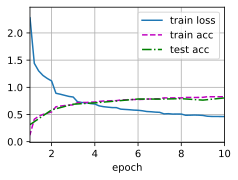

In [62]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())